In [1]:
import pandas as pd
import numpy as np
from random import random
from copy import deepcopy
from sklearn.metrics import mean_absolute_error as mae

from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pmdar
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

def fix_outliers(ts_data):
    Q1, Q2, Q3 = ts_data.quantile([0.25,0.5,0.75])
    IQR = Q3 - Q1
    min_val = Q1 - 2*IQR
    max_val = Q3 + 2*IQR
    return ts_data.clip(lower=min_val, upper=max_val)

def add_lags(df, start_column, n):
    for col in df.iloc[:,start_column:]:
        for i in range(1, n):
            df[col+'_lag_'+str(i)] = df[col].shift(i)
    return df

def normalize_table(data):
    for col in data:
        data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())
    return data

def X_y_split(data):
    X = data.drop(['pm', 'pm_6', 'pm_13', 'pm_15'], axis=1)
    y = data['pm']
    return X, y

def ts_data_shift(X, y, i):
    X_shifted = X.iloc[:-i]
    y_shifted = y.shift(-i).dropna(axis=0)
    return X_shifted, y_shifted

def deseason_ts(ts):
    result = {}
    decomp = seasonal_decompose(ts, model="additive", period=365)
    result['resid'] = decomp.trend + decomp.resid
    result['seasonal'] = decomp.seasonal['2016-01-01':'2016-12-31']
    return result

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def deseason_ts(ts):
    result = {}
    decomp = seasonal_decompose(ts, model="additive", period=365)
    result['resid'] = decomp.trend + decomp.resid
    result['seasonal'] = decomp.seasonal['2016-01-01':'2016-12-31']
    return result

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 10), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print('    Augmented Dickey-Fuller Test on "{}"'.format(name), "\n   ", '-'*47)
    print(' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(' Significance Level    = {}'.format(signif))
    print(' Test Statistic        = {}'.format(output["test_statistic"]))
    print(' No. Lags Chosen       = {}'.format(output["n_lags"]))

    for key,val in r[4].items():
        print(' Critical value {} = {}'.format(adjust(key), round(val, 3)))

    if p_value <= signif:
        print(" => P-Value = {}. Rejecting Null Hypothesis.".format(p_value))
        print(" => Series is Stationary.")
    else:
        print(" => P-Value = {}. Weak evidence to reject the Null Hypothesis.".format(p_value))
        print(" => Series is Non-Stationary.")    
    
seed = 42

C:\Anaconda3\envs\python-35\lib\site-packages\xgboost\__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)
Using TensorFlow backend.


<h2>Data</h2>

In [19]:
raw_data = pd.read_excel('Source_Data_2.xlsx')
raw_data.drop(['Date.1', 'Emi PM2.5 (grams per hour) traffic', 'Hourly_modeled_data PM2.5 (ug/m3)'], axis=1, inplace=True)
raw_data.replace(['---', 'nd'], np.nan, inplace=True)
def dumb_dot(text):
    if isinstance(text, str):
        return float(text.replace('.', '', 1))
    return text
raw_data['Sol_rad_w/m2'] = raw_data['Sol_rad_w/m2'].apply(dumb_dot)
raw_data.insert(2, 'weekofyear', raw_data['Date'].dt.weekofyear)
raw_data.insert(4, 'dayofweek', raw_data['Date'].dt.dayofweek)
raw_data.columns = ['date', 'month', 'weekofyear', 'day', 'dayofweek', 'hour', 'pm', 'temp', 'hum', 'sol', 'rain']
for col in ['pm', 'temp', 'hum', 'sol', 'rain']:
    raw_data[col] = fix_outliers(raw_data[col])
for col in raw_data.iloc[:, 6:]:
    raw_data[col+'_6'] = np.where(raw_data['hour']==6, raw_data[col], np.nan)
    raw_data[col+'_13'] = np.where(raw_data['hour']==13, raw_data[col], np.nan)
    raw_data[col+'_15'] = np.where(raw_data['hour']==15, raw_data[col], np.nan)
raw_data.drop(['hour'], axis=1, inplace=True)
raw_data = raw_data.resample('D', on = 'date').mean()
for col in raw_data.iloc[:, 4:].columns:
    raw_data[col] = fix_outliers(raw_data[col])
raw_data = raw_data['2014-09-01':]
for col in raw_data:
    raw_data[col] = raw_data[col].interpolate(method='time')
for col in raw_data.iloc[:,4:]:
    for i in range(1, 6):
        raw_data[col+'_lag_'+str(i)] = raw_data[col].shift(i)
# raw_data = raw_data.merge(pd.read('../wind.xlsx'), how='left', on='date')
for col in raw_data:
    raw_data[col] = raw_data[col].interpolate(method='time')
raw_data = raw_data.astype({'month':int, 'day':int, 'dayofweek':int, 'weekofyear':int})

In [318]:
import plotly.express as px
fig = px.line(x=data.index, y=data.vel_ms_15)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [2]:
data = pd.read_excel('data.xlsx').set_index('date').bfill()
pm_max, pm_min = data['pm'].max(), data['pm'].min()
y_wrf = pd.read_excel('Source_data_2.xlsx', sheet_name= 'y_wrf')
y_wrf = y_wrf.set_index('Date')['WRF']
y_wrf = (y_wrf-pm_min)/(pm_max-pm_min)
y_obs = data['pm'].copy(deep=True).iloc[:27]
y_obs = (y_obs-pm_min)/(pm_max-pm_min)
# data = normalize_table(data)
data.index.freq = 'D'
print("Enemy's MAE: {:.3}".format(mae(y_obs, y_wrf)))
print("Enemy's MAPE: {:.2%}".format(mape(y_obs, y_wrf)/100))

Enemy's MAE: 0.096
Enemy's MAPE: 49.01%


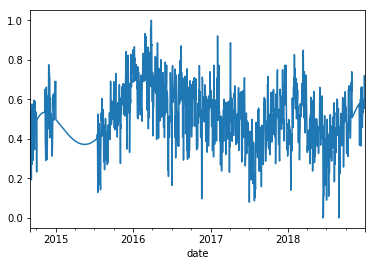

In [17]:
data.temp.plot()

In [11]:
data[['pm', 'temp', 'hum', 'sol', 'dir_grados', 'vel_ms']].describe().round(2)

,pm,temp,hum,sol,dir_grados,vel_ms
count,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00
mean,9.15,15.25,64.40,191.89,161.79,1.72
std,3.81,1.12,8.06,70.96,50.66,0.34
min,0.00,11.30,25.59,0.00,11.08,0.46
25%,6.57,14.42,59.45,130.56,129.70,1.60
50%,8.99,15.23,64.67,186.47,157.12,1.64
75%,11.51,15.98,69.24,244.39,189.01,1.92
max,21.40,19.11,91.12,472.04,307.62,3.02


<h2>Model choice</h2>

In [3]:
X_train, y_train = X_y_split(data)
X_train, y_train = ts_data_shift(X_train, y_train, 1)

In [ ]:
models = [("LinearRegression",LinearRegression()),
          ("Ridge", Ridge(random_state=seed)),
          ("Lasso", Lasso(random_state=seed)),
          ("SVR", SVR()),
          ("RF", RandomForestRegressor(random_state=seed)),
          ("ET", ExtraTreesRegressor(random_state=seed)),
          ("BR", GradientBoostingRegressor(random_state=seed)),
          ("LGBM", LGBMRegressor(random_state=seed)),
          ("XGB", XGBRegressor(seed=seed))]

scoring = 'neg_mean_absolute_error'
n_folds = 5
results, names  = [], [] 

for name, model  in models:
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train.values, y_train.values, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)
    print('{}: {} (+/- {})'.format(name, cv_results.mean(), cv_results.std()))

LinearRegression: -2.3071395785242728 (+/- 0.06768164401235091)
Ridge: -2.2933371877648194 (+/- 0.07854608831855978)
Lasso: -2.371516789287793 (+/- 0.07751904190882059)
SVR: -2.5870973139456117 (+/- 0.10408433198551019)


In [15]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*mae(Y, self.predictions)))
        

In [16]:
lr = Class_Fit(clf = Lasso)
lr.grid_search(parameters = [{'alpha':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)

C:\Anaconda3\envs\python-35\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Anaconda3\envs\python-35\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

C:\Anaconda3\envs\python-35\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.307430189654408, tolerance: 0.003283814281748306

C:\Anaconda3\envs\python-35\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

C:\Anaconda3\envs\python-35\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning:

Co

In [23]:
lr.grid.best_params_

{'alpha': 0}

In [24]:
lr = Class_Fit(clf = Ridge)
lr.grid_search(parameters = [{'alpha':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)

In [25]:
lr.grid.best_params_

{'alpha': 1}

In [40]:
svc = Class_Fit(clf = SVR)
svc.grid_search(parameters = {'C':[1, 2, 5, 10, 15, 25, 50],
                             'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
                , Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)

In [41]:
svc.grid.best_params_

{'C': 2, 'kernel': 'linear'}

In [42]:
svc.grid.best_score_

0.0008386135434965524

In [34]:
rf = Class_Fit(clf = RandomForestRegressor)
param_grid = { 'n_estimators' : [10, 50, 75, 100, 150],
               'min_samples_leaf' :[10, 50, 100, 150],
             'max_depth': [5, 10, 15]}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)

In [35]:
rf.grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}

In [47]:
lg = Class_Fit(clf = LGBMRegressor)
param_grid = {'n_estimators':[10, 50, 100], 
              'max_depth':[2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.15],
              'num_leaves': [10, 50, 100, 250, 200, 500]
             }
lg.grid_search(parameters = param_grid, Kfold = 5)
lg.grid_fit(X = X_train, Y = Y_train)

In [48]:
lg.grid.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}

In [51]:
xg = Class_Fit(clf = XGBRegressor)
param_grid =  {
    'n_estimators': [50, 100, 150],
        'max_depth': range(5, 16, 5), 
    'lambda':[1, 2],
    'gamma':[0,1,2]
               }
xg.grid_search(parameters = param_grid, Kfold = 5)
xg.grid_fit(X = X_train, Y = Y_train)

KeyboardInterrupt: 

In [ ]:
xg.grid.best_params_

In [7]:
X_train, X_test = X_train.iloc[:-30], X_train.iloc[-30:]
y_train, y_test = y_train[:-30], y_train[-30:]

In [9]:
models = [("LinearRegression",LinearRegression()),
          ("Ridge", Ridge(random_state=seed)),
          ("Lasso", Lasso(random_state=seed)),
          ("SVR", SVR()),
          ("RF", RandomForestRegressor(random_state=seed)),
          ("ET", ExtraTreesRegressor(random_state=seed)),
          ("BR", GradientBoostingRegressor(random_state=seed)),
          ("LGBM", LGBMRegressor(random_state=seed)),
          ("XGB", XGBRegressor(seed=seed))]

In [ ]:
from time import time

In [17]:
for name, model  in models:
    print(name)
    a = time()
    model.fit(X_train, y_train)
    print('fit time:', (time() - a)*30)
    b = time()
    model.predict(X_test)
    print('predict time:', (time() - b)*30)

LinearRegression
fit time: 2.9691267013549805
predict time: 0.15151262283325195
Ridge
fit time: 0.5440020561218262
predict time: 0.07596731185913086
Lasso
fit time: 0.365753173828125
predict time: 0.0299835205078125
SVR
fit time: 13.859281539916992
predict time: 0.14965295791625977
RF
fit time: 514.7120118141174
predict time: 0.7357192039489746
ET
fit time: 198.80104064941406
predict time: 0.31605005264282227
BR
fit time: 230.5081558227539
predict time: 0.1049351692199707
LGBM
fit time: 141.01329803466797
predict time: 2.263827323913574
XGB
fit time: 144.55404996871948
predict time: 0.2115797996520996


<h2>Final model</h2>

In [38]:
model = GradientBoostingRegressor()

param_grid_et =  {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [50, 100, 150]
               }

grid_rf = GridSearchCV(estimator=model,
                               param_grid= param_grid_et,
                               scoring= 'neg_mean_absolute_error',
                               cv = KFold(n_splits=5, random_state=seed, shuffle=True),
                               n_jobs = 4,
                               verbose = 10)
# Fit grid
grid_rf.fit(X_train, y_train)

# Best score and best parameters
print('-------Best score----------')
print(grid_rf.best_score_ )
print('-------Best params----------')
print(grid_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min


KeyboardInterrupt: 

In [43]:
model = GradientBoostingRegressor(random_state=seed, 
                                   min_samples_leaf=100, 
                                   max_depth=10,
                                   n_estimators=100,
                                   learning_rate=0.1)

# model.fit(X_train, y_train)

In [45]:
scoring = 'neg_mean_absolute_error'
n_folds = 5

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
cv_results = cross_val_score(model, X_train, Y_train, cv= kfold,
                             scoring=scoring, n_jobs=-1)    

print('GBR: {} (+/- {})'.format(cv_results.mean(), cv_results.std()))

GBR: -0.10903257561299044 (+/- 0.00331688323485238)


In [20]:
data.pm.to_excel('../pm.xlsx')

<h2>Direct forecasting setup</h2>

In [6]:
class DirectForecastModel:
    def __init__(self, model, n_steps):
        self.model = model
        self.n_steps = n_steps
    
    def fit_predict(self, data):
        self.prediction = {}
        self.X, self.y = X_y_split(data)
        X_pred = self.X.iloc[0, :]
        self.dict_of_models = {}
        for i in range(1, self.n_steps+1):
            X_train, y_train = ts_data_shift(self.X, self.y, i)
            model_fit = self.model.fit(X_train, y_train)
            self.prediction[i] = model_fit.predict(X_pred.values.reshape(1, 144))
        return [i[0] for i in self.prediction.values()]                

In [ ]:
model = DirectForecastModel(GradientBoostingRegressor(), 60)

In [ ]:
pred = model.fit_predict(data.iloc[:-60,])

In [ ]:
y_obs = data.iloc[-60:,].pm

In [ ]:
mean_absolute_percentage_error(pred, y_obs)

<h2>VAR</h2>

In [3]:
df = data[['pm', 'temp', 'hum', 'sol', 'dir_grados', 'vel_ms']].copy(deep=True)
# df = df.iloc[::-1].reset_index().drop(['date'], axis=1)
df.index.freq='D'

In [4]:
data_var_train, data_var_test = df.iloc[:-27], df.iloc[-27:]
print(data_var_train.shape, data_var_test.shape)

(1556, 6) (27, 6)


In [5]:
for name, column in data_var_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9256
 No. Lags Chosen       = 13
 Critical value 10%    = -2.568
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 => P-Value = 3.1086e-05. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9666
 No. Lags Chosen       = 12
 Critical value 10%    = -2.568
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 => P-Value = 2.58267e-05. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hum" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [6]:
model = VAR(data_var_train, freq='D')
var = model.fit(maxlags=20, ic='aic')
y_hat = var.forecast(y=data_var_test.values, steps=data_var_test.shape[0]) 

In [7]:
print('VAR error on September data: {}'.format(mae(y_hat[:,0], data_var_test['pm'])))

VAR error on September data: 0.09997125719097982


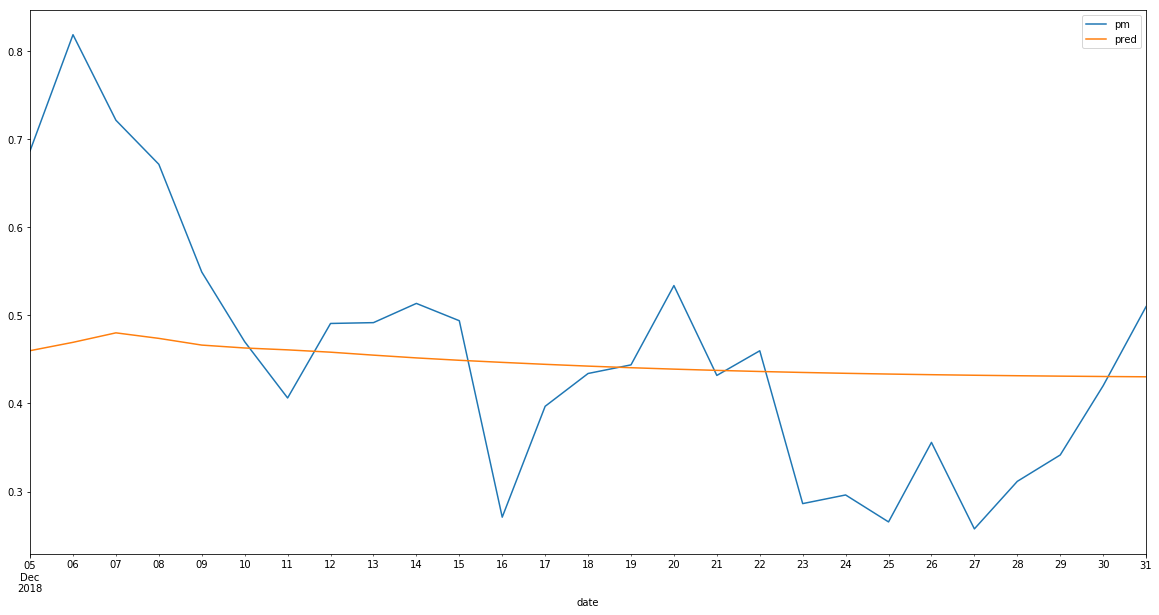

In [8]:
df = pd.DataFrame([data_var_test.pm]).T
df['pred'] = y_hat[:,0]
df.plot(figsize=(20,10));

<h2>ExponentialSmoothing</h2>

In [9]:
data_ex = data[['pm']].copy(deep=True)
data_ex.index.freq='D'

In [10]:
train, test = data_ex.iloc[:1000], data_ex.iloc[1000:]
print(train.shape, test.shape)

(1000, 1) (583, 1)


C:\Anaconda3\envs\python-35\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\Anaconda3\envs\python-35\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Anaconda3\envs\python-35\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



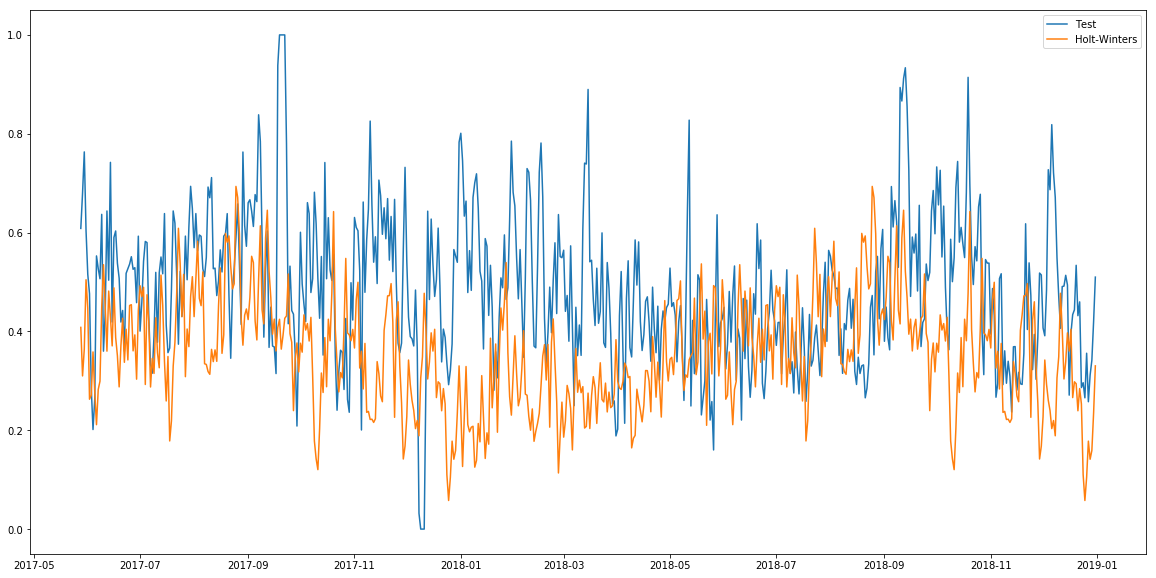

In [11]:
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.figure(figsize=(20,10))
plt.plot(test, label='Test')
plt.plot(pred, label='Holt-Winters')
plt.legend(loc='best');

In [12]:
print('ExponentialSmoothing error: {}'.format(mae(pred, test['pm'])))

ExponentialSmoothing error: 0.17919358761126386


<h2>Auto SARIMA PM</h2>

In [ ]:
pm0.plot(figsize=(20,10));

In [ ]:
pm0 = deepcopy(data.pm)
pm0 = pm0.interpolate(method='spline', order=5).iloc[::-1]
pm0_train, pm0_test = pm0[:'2014-10-01'], pm0['2014-09-30':]

In [ ]:
pm0 = deepcopy(data.pm)
pm0 = pm0.interpolate(method='spline', order=5)
pm0_train, pm0_test = pm0.iloc[:-30], pm0[-30:]

In [ ]:
stepwise_fit = pmdar.auto_arima(pm0_train, 
                             start_p=1, max_p=10,
                             start_q=1, max_q=10,
                             start_P=0, max_P=10,
                             start_Q=0, max_Q=10,
                             m=12, d=None, D=None,
                             seasonal=True, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True, stepwise=True)

stepwise_fit.summary()

In [ ]:
# yhat = stepwise_fit.predict(30)
print(mae(yhat, pm0_test))
plt.plot(pm0_test.values, label='Test')
plt.plot(yhat, label='SARIMAX')
plt.legend(loc='best');

In [ ]:
model = SARIMAX(, order=(2,0,1), seasonal_order=(0,0,0,12))

## Neural Network

In [77]:
X = data.drop(['pm', 'pm_6', 'pm_13', 'pm_15'], axis=1).values
Y = data['pm'].values
def deeper_model():
    model = Sequential()
    model.add(Dense(144, input_dim=144, kernel_initializer='normal', activation='relu'))
    model.add(Dense(200, input_dim=144, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, input_dim=50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, input_dim=50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=deeper_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Deeper: %.2f (%.2f) MAE" % (results.mean(), results.std()))

Deeper: -0.11 (0.01) MAE


<h2>LSTM</h2>

<h4>Univariate 1 step pred</h4>

In [508]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [509]:
n_steps = 7
X, y = split_sequence(data.pm, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))
n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]

In [510]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose=0, shuffle=False)

Test MAE: 0.096


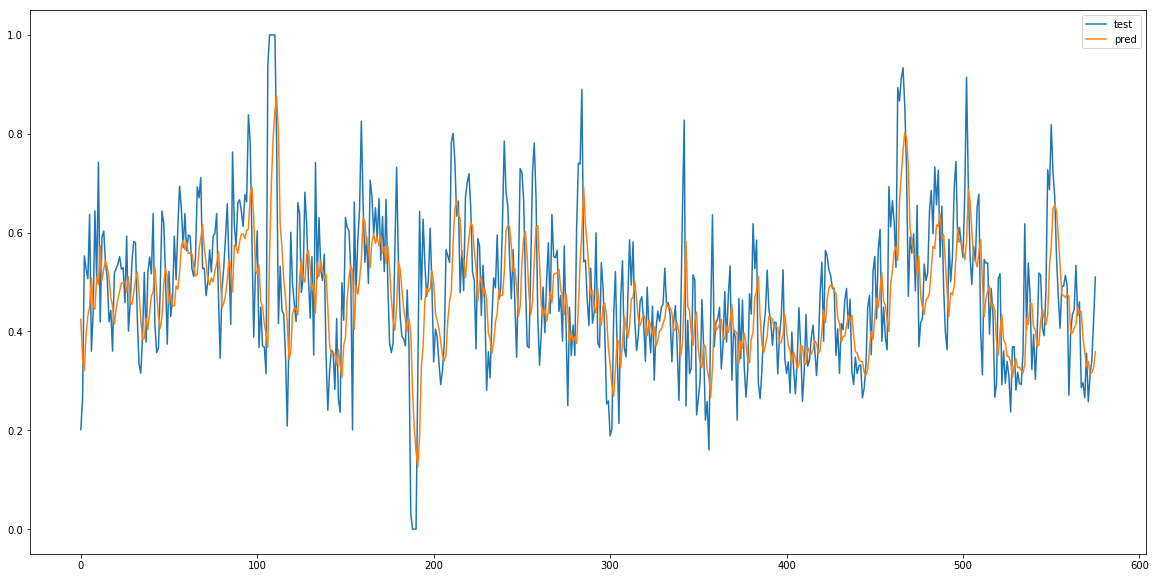

In [511]:
yhat = model.predict(X_test)
MAE = mae(yhat, y_test)
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test, label='test')
plt.plot(yhat, label='pred')
plt.legend()
plt.show()

<h3>CNN</h3>

In [3]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

<h4>CNN Single Channel 1 step pred for PM</h4>

In [23]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [25]:
n_features = 1
n_steps = 5
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

X, y = split_sequence(data.pm, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))
n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]
model.fit(X_train, y_train, batch_size=100, epochs=50, verbose=0)

Test MAE: 0.094


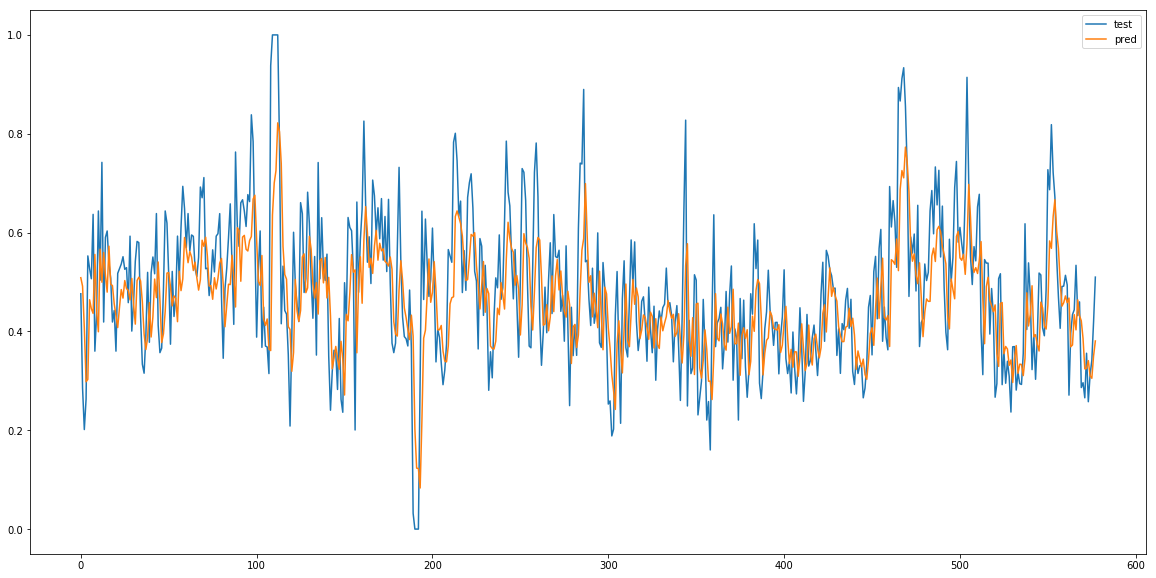

In [26]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat, y_test)
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test, label='test')
plt.plot(yhat, label='pred')
plt.legend()
plt.show()

<h4>CNN Multichannel 1 step pred for PM</h4>

In [59]:
# def split_sequences(sequences, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequences)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the dataset
# 		if end_ix > len(sequences):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return np.array(X), np.array(y)

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [72]:
n_features = 4
n_steps = 100
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(100))
model.compile(optimizer='adam', loss='mse')

In [73]:
data_cnn = data[['temp', 'hum', 'sol', 'pm']]
data_cnn = pd.concat([data_cnn, data_cnn.pm.shift(1)], axis=1).dropna(axis=0)
X, y = split_sequences(data_cnn.values, n_steps, n_steps)
n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]
model.fit(X_train, y_train, batch_size=100, epochs=50, verbose=0)

In [74]:
y_test.shape

(384, 100)

Test MAE: 0.128


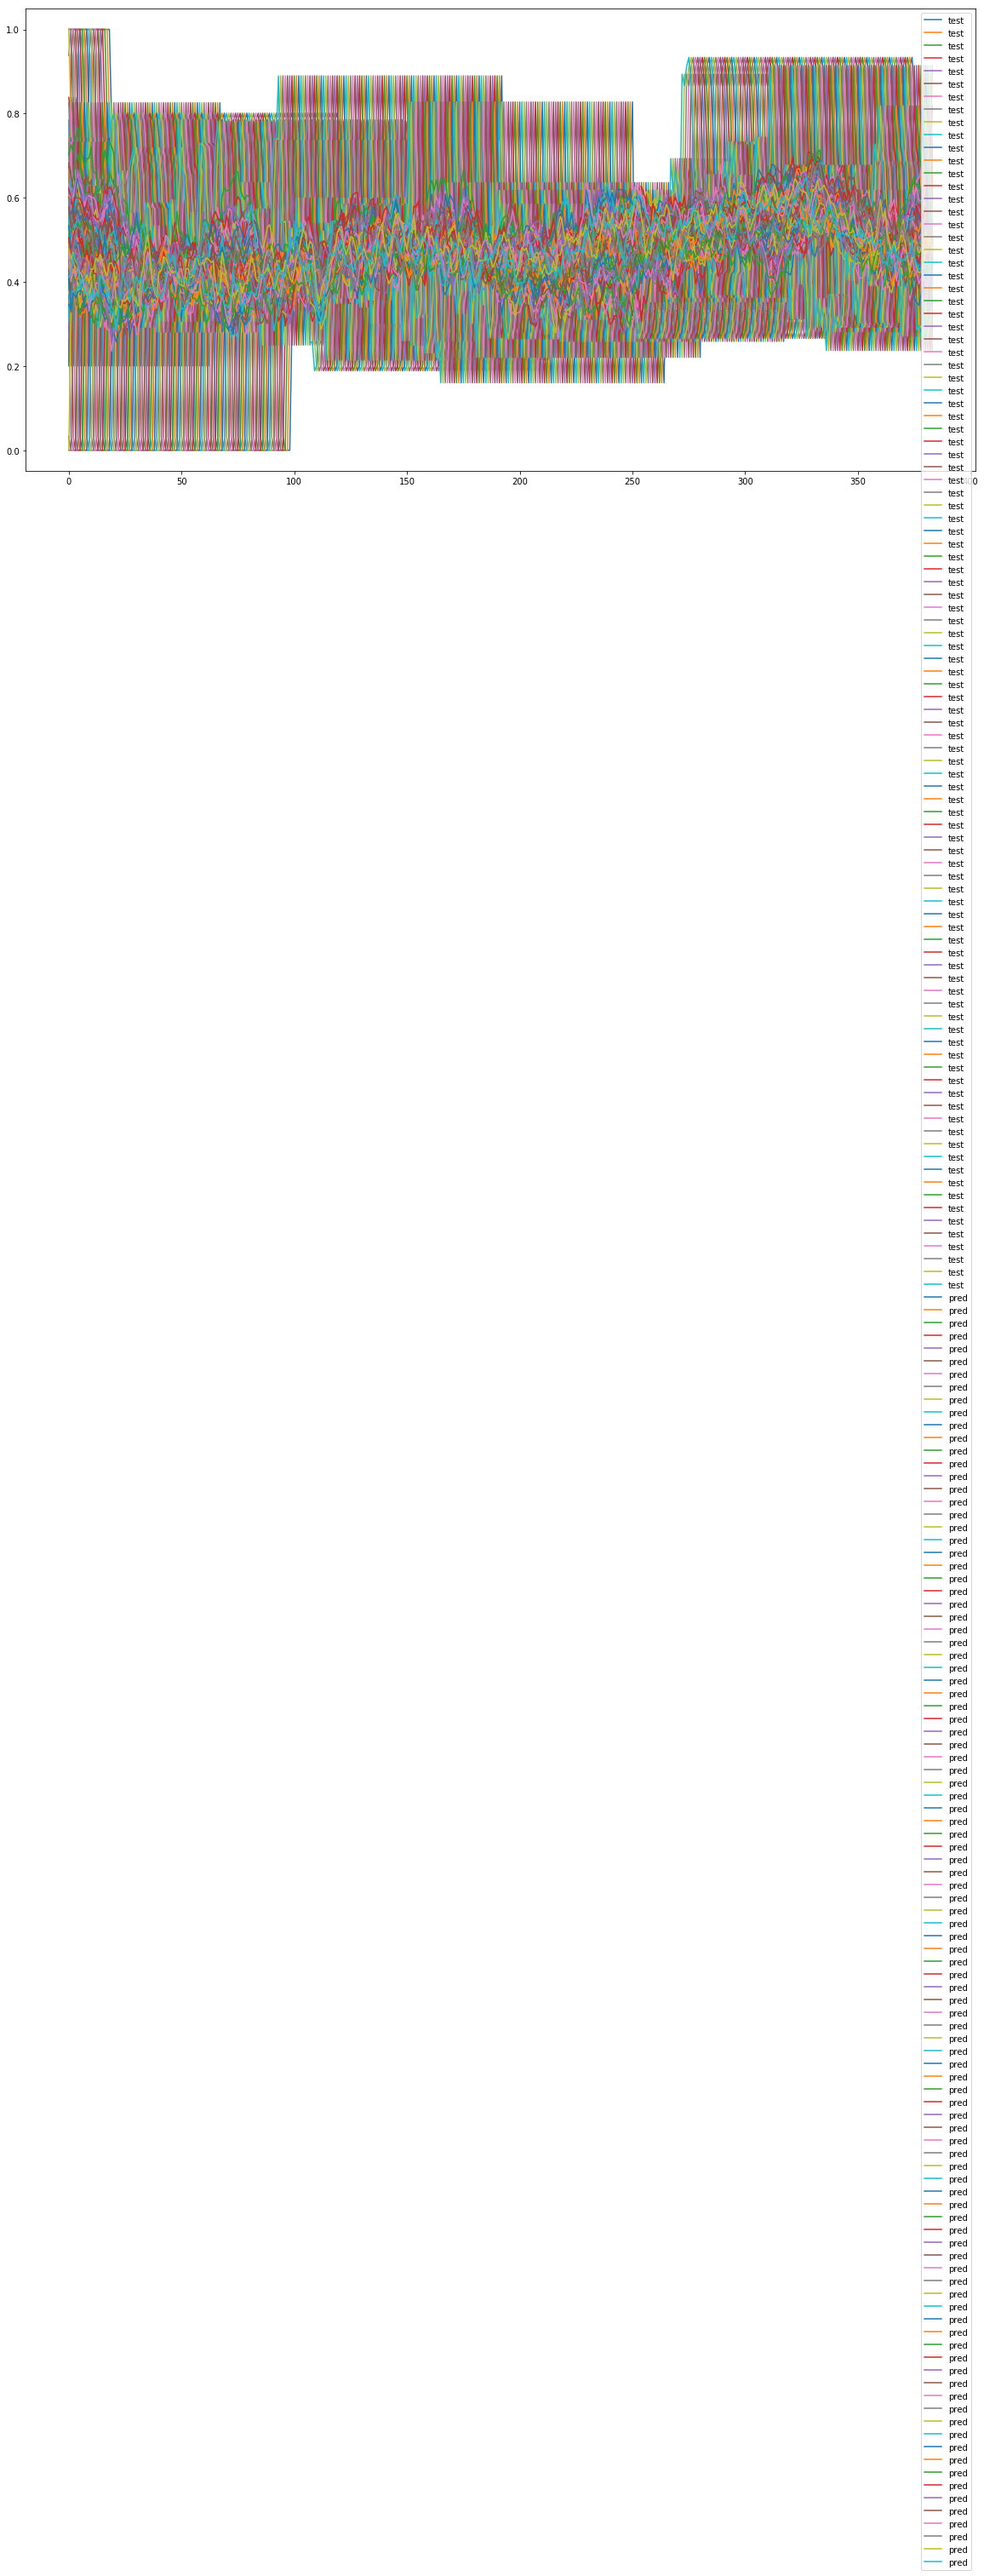

In [75]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat, y_test)
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test, label='test')
plt.plot(yhat, label='pred')
plt.legend()
plt.show()

<h4>CNN Multichannel 1 step pred for Channels</h4>

In [413]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [414]:
n_steps = 7
# convert into input/output
X, y = split_sequences(data_cnn.values, n_steps)
n_features = X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)

Test MAE: 0.095


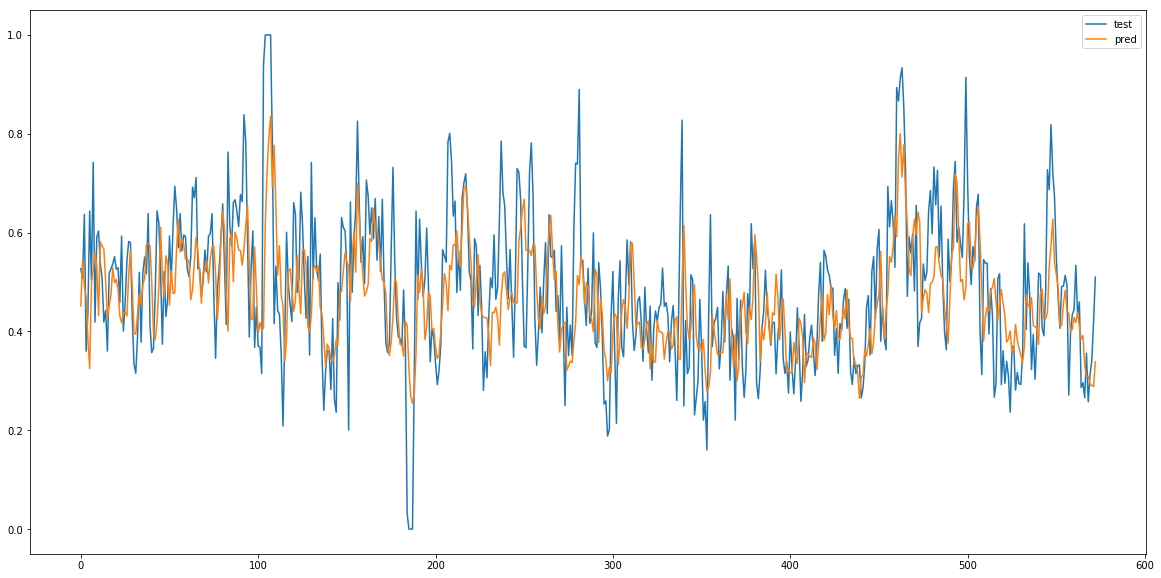

In [415]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat[:,3], y_test[:,3])
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test[:,3], label='test')
plt.plot(yhat[:,3], label='pred')
plt.legend()
plt.show()

<h4>CNN Single channel Multi step pred for PM</h4>

In [436]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [441]:
n_steps_in, n_steps_out = 10, 1
X, y = split_sequence(data.pm, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)

Test MAE: 0.113


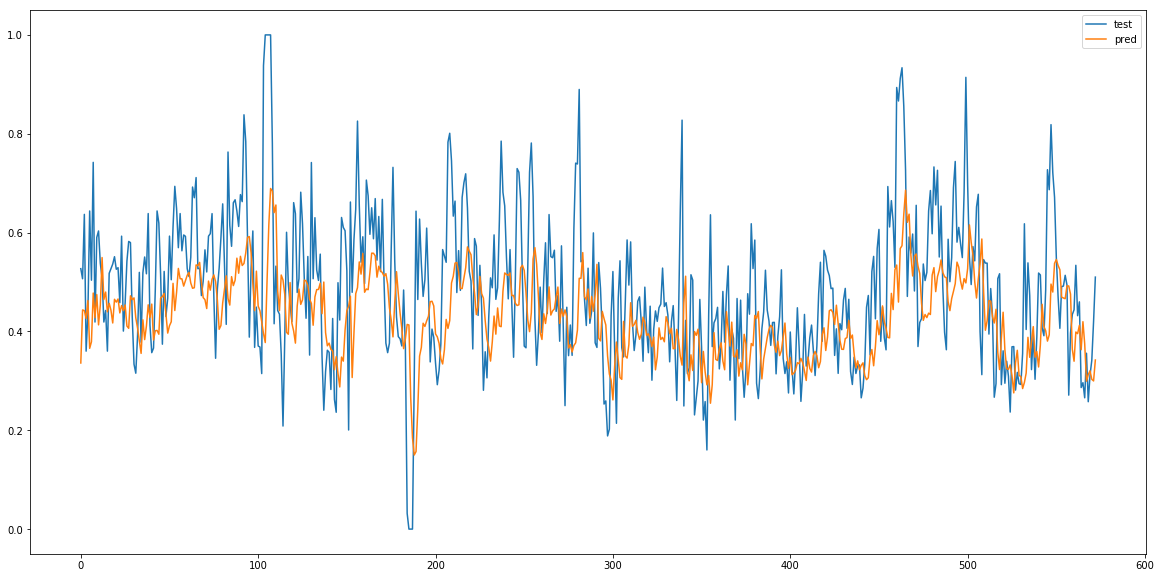

In [442]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat[:,0], y_test[:,0])
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test[:,0], label='test')
plt.plot(yhat[:,0], label='pred')
plt.legend()
plt.show()

<h4>CNN Multichannel Multistep for PM</h4>

In [450]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

data_cnn = data[['temp', 'hum', 'sol', 'pm']]
data_cnn = pd.concat([data_cnn, data_cnn.pm], axis=1).dropna(axis=0)
n_steps_in, n_steps_out = 30, 10 
# convert into input/output
X, y = split_sequences(data_cnn.values, n_steps_in, n_steps_out)

n_train_days = 1000
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)

Test MAE: 0.099


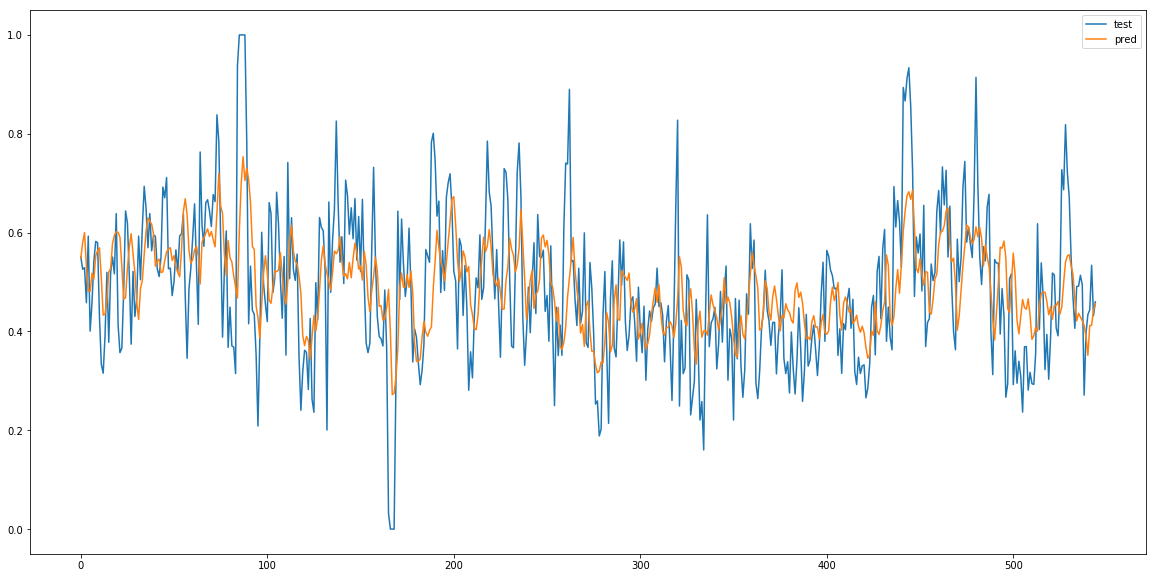

In [451]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat[:,0], y_test[:,0])
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test[:,0], label='test')
plt.plot(yhat[:,0], label='pred')
plt.legend()
plt.show()

<h4>CNN Multichannel Multistep for Channels</h4>

In [452]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [460]:
n_steps_in, n_steps_out = 30, 10
data_cnn = data[['temp', 'hum', 'sol', 'pm']]
X, y = split_sequences(data_cnn.values, n_steps_in, n_steps_out)
n_train_days = 1000
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]
X_train, X_test = X[:n_train_days], X[n_train_days:]
y_train, y_test = y[:n_train_days], y[n_train_days:]

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)# demonstrate prediction

Test MAE: 0.121


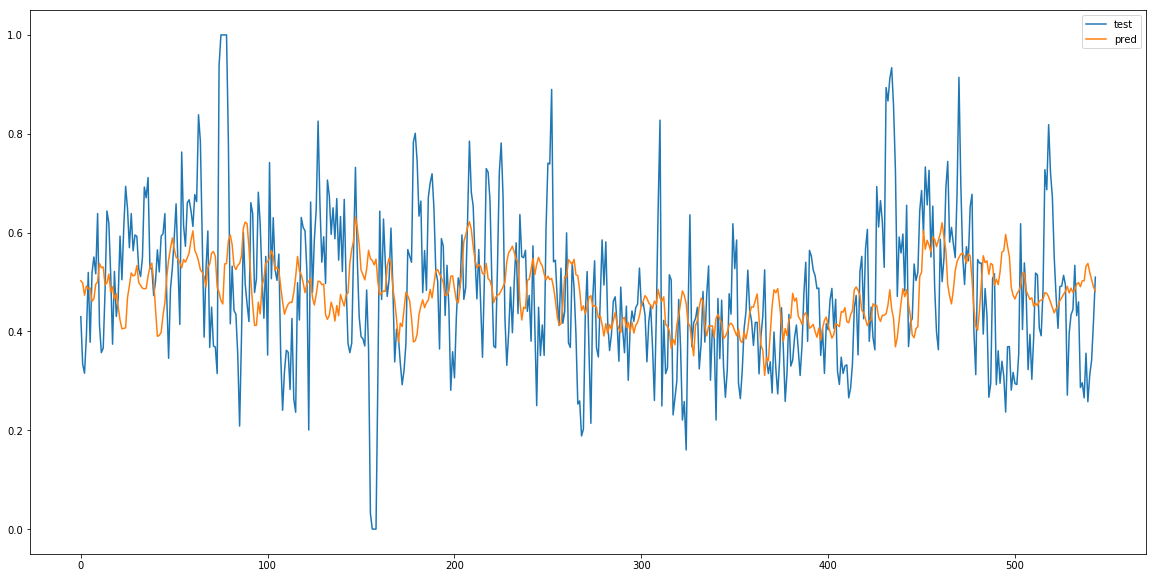

In [472]:
yhat = model.predict(X_test, verbose=0)
MAE = mae(yhat[:,39], y_test[:,39])
print('Test MAE: %.3f' % MAE)
plt.figure(figsize=(20,10))
plt.plot(y_test[:,39], label='test')
plt.plot(yhat[:,39], label='pred')
plt.legend()
plt.show()